In [1]:
import argparse
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lib.model.DataModel import Data
from lib.model.BayesModel import BaseLineModel
from lib.model.KalmanFilterModel import KalmanFilterChangePointModel
from lib.utils import gaussian

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

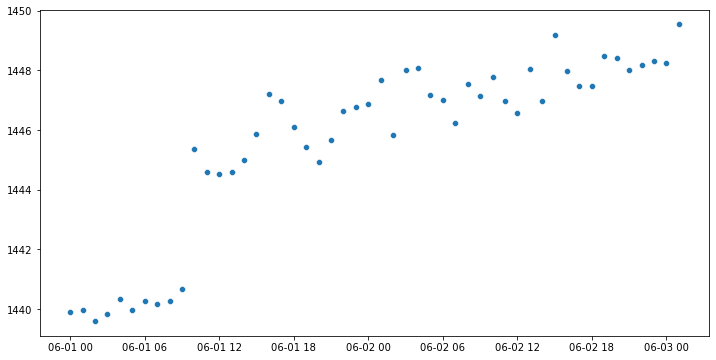

In [3]:
zs, ts, _ = BaseLineModel.sample_data(N=50, sp_loc=0.2, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6)

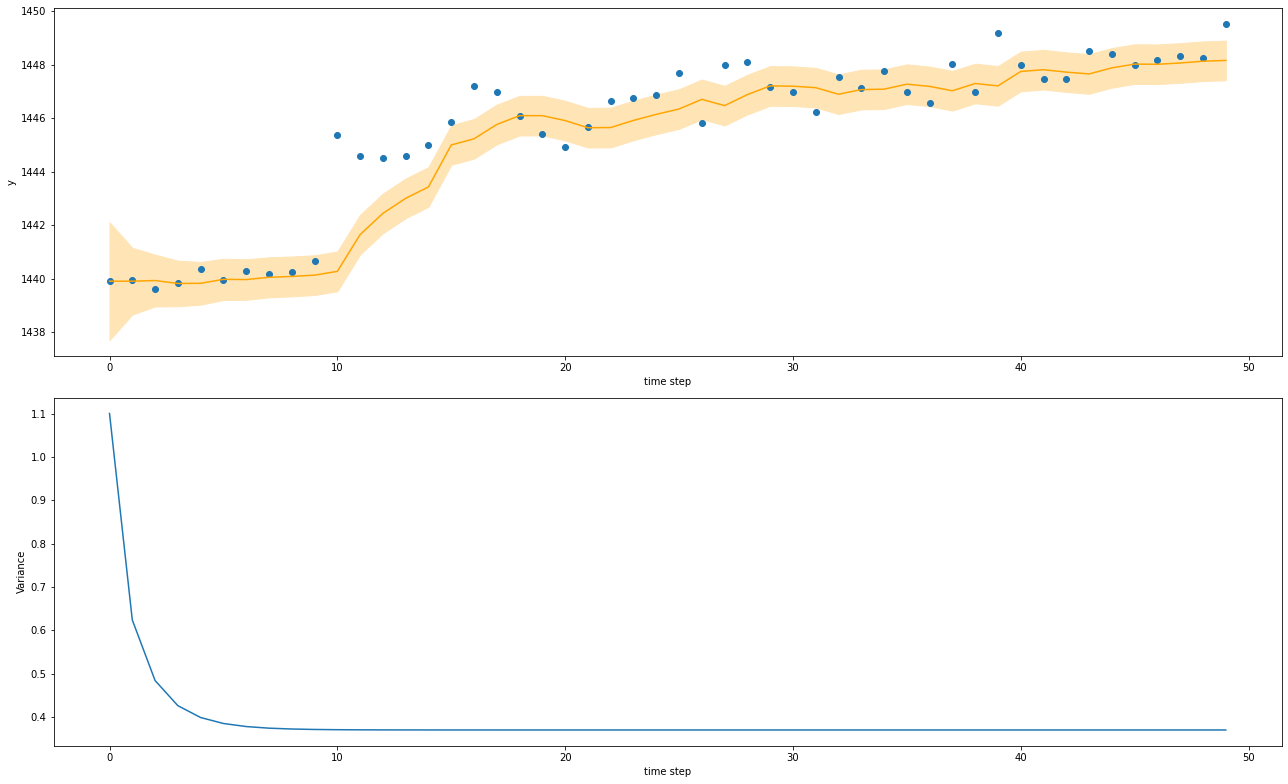

In [25]:
smoothing_param = 0.1
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)

In [26]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

In [ ]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)

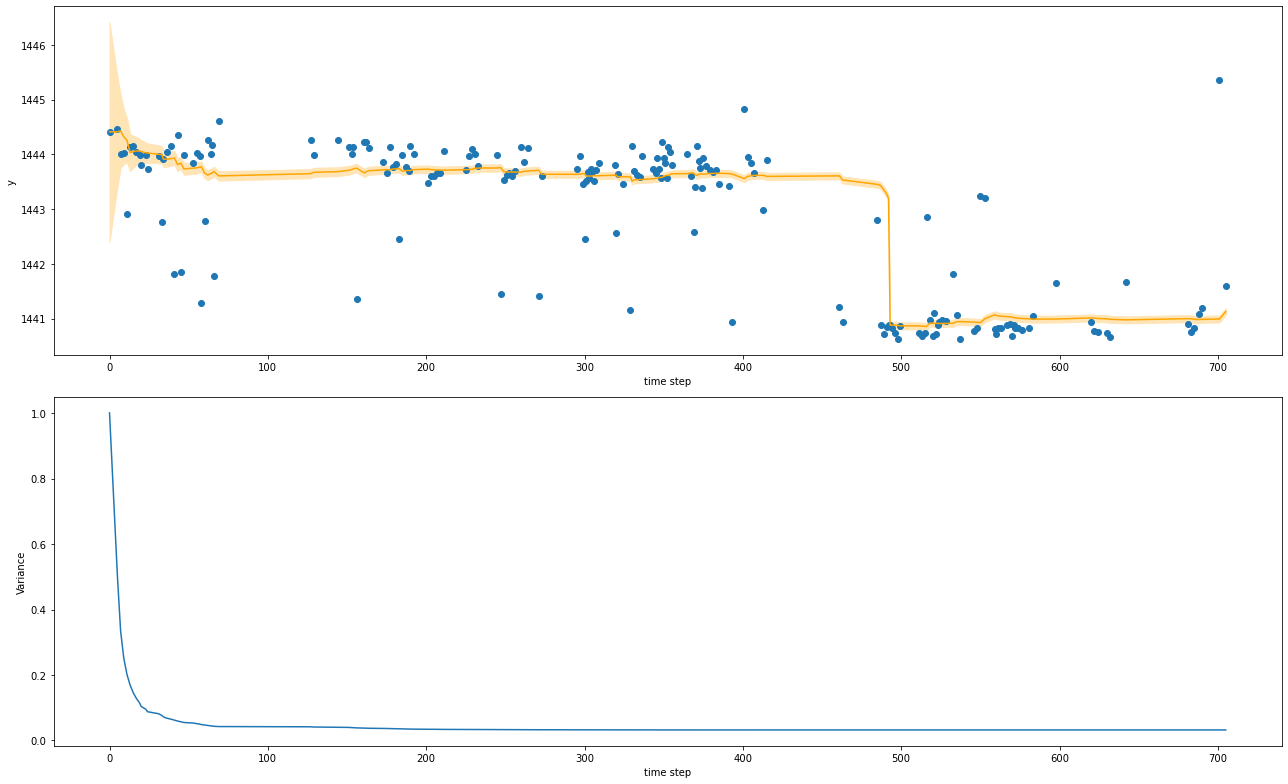

In [31]:
zs = sp_model.y
ts = sp_model.t
smoothing_param = 0.001
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)